# Hybrid Rule-Based Regime + ML Regression Strategy v2

## FIXED VERSION - No Data Leakage

### Key Fixes:
1. **Regression Target A/B Test**:
   - Option A: Close-to-Close return (conservative, realistic)
   - Option B: VWAP return (volume-weighted average exit)
2. **Regime Look-Ahead Fix**: Use previous day's regime (1-day lag)
3. **Realistic Execution**: Entry at next bar open with slippage
4. **Intra-Bar Stop Loss**: Check if stop hit during holding period

### Architecture
1. **Rule-Based Regime Detection**: MACD + FD momentum on daily timeframe (1-day lag)
2. **ML Regression Models**: Train TWO models (Option A vs Option B)
3. **A/B Testing**: Compare both approaches in backtesting
4. **Benchmark**: Compare against rule-based and original (leaky) version

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Import PyCaret for comprehensive regression model comparison
from pycaret.regression import *

plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Starting Hybrid ML Regression Strategy v2 - FIXED VERSION")
print("A/B Testing: Close-to-Close vs VWAP Target")
print("Regime: 1-Day Lag (No Look-Ahead Bias)")
print("=" * 70)

Starting Hybrid ML Regression Strategy v2 - FIXED VERSION
A/B Testing: Close-to-Close vs VWAP Target
Regime: 1-Day Lag (No Look-Ahead Bias)


## 1. Load Data and Configuration

In [2]:
# Strategy configuration
CONFIG = {
    'stop_loss_pct': 0.04,         # 4% stop loss
    'lookforward_hours': 24,       # Look forward 24 hours for target
    'commission': 0.0075,          # 0.75% commission per trade
    'slippage': 0.0001,            # 0.01% slippage per trade
    'regime_timeframe': '1D',      # Daily regime detection
    'regime_lag_days': 1,          # Use previous day's regime (FIX)
    'train_test_split': 0.70,      # 70% train, 30% test
    'min_entry_return': 0.05,      # Minimum predicted return to enter (5%)
}

print("Strategy Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Load 1-minute data
df = pd.read_csv('../data/BTCUSD_2023_1min_cleaned.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Clean unnecessary columns
cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(columns=cols_to_drop, errors='ignore')

print(f"\nData loaded: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Available features: {list(df.columns)}")

Strategy Configuration:
  stop_loss_pct: 0.04
  lookforward_hours: 24
  commission: 0.0075
  slippage: 0.0001
  regime_timeframe: 1D
  regime_lag_days: 1
  train_test_split: 0.7
  min_entry_return: 0.05

Data loaded: (434438, 25)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00
Available features: ['Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend', 'fd_7d', 'fd_30d']


## 2. Rule-Based Regime Classification - FIXED (1-Day Lag)

**KEY FIX**: Use PREVIOUS day's regime to avoid look-ahead bias

- At 2023-10-23 00:00:00, use 2023-10-22's regime classification
- Regime calculated from prior day's close, MACD, FD
- Realistic for production deployment

In [3]:
def classify_momentum_regimes_daily_NO_LOOKAHEAD(df_1min, lag_days=1):
    """
    FIXED: Rule-based momentum regime classification on daily timeframe
    Uses PREVIOUS day's regime to avoid look-ahead bias
    
    Args:
        lag_days: Number of days to lag regime (default 1 = use yesterday's regime)
    """
    # Aggregate to daily
    agg_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }
    
    # Include existing indicators if available
    for col in ['macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'fd_14d', 'fd_7d', 'fd_30d']:
        if col in df_1min.columns:
            agg_dict[col] = 'last'
    
    df_daily = df_1min.resample('1D').agg(agg_dict).dropna()
    
    # Calculate daily returns and volatility
    df_daily['return'] = df_daily['Close'].pct_change()
    df_daily['return_5p'] = df_daily['Close'].pct_change(5)
    df_daily['volatility'] = df_daily['return'].rolling(5).std()
    
    # Initialize regime conditions
    bull_condition = pd.Series(False, index=df_daily.index)
    bear_condition = pd.Series(False, index=df_daily.index)
    
    # MACD-based momentum
    if 'macd_hist_12_26' in df_daily.columns and 'macd_12_26' in df_daily.columns:
        macd_bull = (
            (df_daily['macd_12_26'] > df_daily['macd_sig_12_26']) & 
            (df_daily['macd_hist_12_26'] > 0) &
            (df_daily['macd_hist_12_26'] > df_daily['macd_hist_12_26'].shift(1))
        )
        
        macd_bear = (
            (df_daily['macd_12_26'] < df_daily['macd_sig_12_26']) & 
            (df_daily['macd_hist_12_26'] < 0) &
            (df_daily['macd_hist_12_26'] < df_daily['macd_hist_12_26'].shift(1))
        )
        
        bull_condition |= macd_bull
        bear_condition |= macd_bear
    
    # Fractal Dimension-based regime
    if 'fd_14d' in df_daily.columns:
        if 'fd_7d' in df_daily.columns and 'fd_30d' in df_daily.columns:
            fd_bull = (df_daily['fd_7d'] > df_daily['fd_30d']) & (df_daily['fd_14d'] > 1.3)
            fd_bear = (df_daily['fd_7d'] < df_daily['fd_30d']) & (df_daily['fd_14d'] > 1.5)
        else:
            fd_ma = df_daily['fd_14d'].rolling(5).mean()
            fd_trend = df_daily['fd_14d'] - fd_ma
            fd_bull = (fd_trend > 0) & (df_daily['fd_14d'] > df_daily['fd_14d'].rolling(10).quantile(0.6))
            fd_bear = df_daily['fd_14d'] > df_daily['fd_14d'].rolling(20).quantile(0.8)
        
        bull_condition |= fd_bull
        bear_condition |= fd_bear
    
    # Price momentum confirmation
    if 'return_5p' in df_daily.columns:
        price_bull = df_daily['return_5p'] > df_daily['return_5p'].rolling(10).quantile(0.7)
        price_bear = df_daily['return_5p'] < df_daily['return_5p'].rolling(10).quantile(0.3)
        
        bull_condition &= price_bull
        bear_condition &= price_bear
    
    # Assign regimes: 2=Bull, 1=Sideways, 0=Bear
    df_daily['regime'] = np.where(bull_condition, 2, np.where(bear_condition, 0, 1))
    
    # KEY FIX: SHIFT REGIME BY lag_days
    # Today's trading uses YESTERDAY's regime classification
    df_daily['regime_lagged'] = df_daily['regime'].shift(lag_days)
    
    # Map regimes back to 1-minute data using LAGGED regime
    df_result = df_1min.copy()
    df_result['period'] = df_result.index.floor('D')
    
    regime_map = dict(zip(df_daily.index, df_daily['regime_lagged']))
    df_result['regime'] = df_result['period'].map(regime_map)
    df_result['regime'] = df_result['regime'].fillna(method='ffill')
    df_result = df_result.drop('period', axis=1)
    
    return df_result, df_daily

# Apply regime classification with lag
print(f"Applying rule-based momentum regime classification...")
print(f"Regime lag: {CONFIG['regime_lag_days']} day(s) - No look-ahead bias")
print()

df_with_regimes, df_daily_regimes = classify_momentum_regimes_daily_NO_LOOKAHEAD(
    df, 
    lag_days=CONFIG['regime_lag_days']
)

# Show regime distribution
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
regime_counts = df_with_regimes['regime'].value_counts().sort_index()

print("\nRegime Distribution (1-minute data with 1-day lag):")
for regime, count in regime_counts.items():
    pct = count / len(df_with_regimes) * 100
    print(f"  {regime_names[regime]:>8} ({regime}): {count:>6,} bars ({pct:>5.1f}%)")

print(f"\nDaily regime periods: {len(df_daily_regimes)}")
print(f"Regime changes: {(df_daily_regimes['regime'].diff() != 0).sum()}")

# Verify lag
print(f"\nVerifying 1-day lag (first 5 days):")
print(df_daily_regimes[['regime', 'regime_lagged']].head())

Applying rule-based momentum regime classification...
Regime lag: 1 day(s) - No look-ahead bias


Regime Distribution (1-minute data with 1-day lag):
      Bear (0.0): 73,553 bars ( 16.9%)
  Sideways (1.0): 296,067 bars ( 68.1%)
      Bull (2.0): 63,378 bars ( 14.6%)

Daily regime periods: 325
Regime changes: 71

Verifying 1-day lag (first 5 days):
            regime  regime_lagged
timestamp                        
2023-02-10       1            NaN
2023-02-11       1            1.0
2023-02-12       1            1.0
2023-02-13       1            1.0
2023-02-14       1            1.0


## 3. Create Regression Targets - A/B Test

### Option A: Close-to-Close Return (Conservative)
- Exit at close after 24 hours
- Most realistic and executable
- Lower variance in targets

### Option B: VWAP Return (Volume-Weighted)
- Exit at volume-weighted average price
- Simulates gradual position exit
- More sophisticated than close-to-close

In [4]:
def create_regression_target_CLOSE_TO_CLOSE(df, stop_loss_pct=0.04, lookforward_hours=24):
    """
    OPTION A: Close-to-Close return
    
    FIXED:
    - Exit at close of lookforward window (realistic)
    - Check if stop loss hit DURING holding period
    - No perfect timing assumption
    """
    df = df.copy()
    lookforward_bars = lookforward_hours * 60
    
    targets = []
    
    for i in range(len(df)):
        if i + lookforward_bars >= len(df):
            targets.append(np.nan)
            continue
        
        entry_price = df.iloc[i]['Close']
        future_window = df.iloc[i+1:i+1+lookforward_bars]
        
        # Check if stop loss hit DURING holding period
        max_loss = (future_window['Low'].min() - entry_price) / entry_price
        
        if max_loss <= -stop_loss_pct:
            # Stop loss hit - exit at stop loss price
            gross_return = -stop_loss_pct
        else:
            # Exit at close of lookforward window (REALISTIC)
            exit_price = df.iloc[i + lookforward_bars]['Close']
            gross_return = (exit_price - entry_price) / entry_price
        
        targets.append(gross_return)
    
    df['target_close'] = targets
    return df


def create_regression_target_VWAP(df, stop_loss_pct=0.04, lookforward_hours=24):
    """
    OPTION B: VWAP (Volume-Weighted Average Price) return
    
    FIXED:
    - Exit at VWAP over holding period
    - More realistic than "best high"
    - Simulates averaging out of position
    """
    df = df.copy()
    lookforward_bars = lookforward_hours * 60
    
    targets = []
    
    for i in range(len(df)):
        if i + lookforward_bars >= len(df):
            targets.append(np.nan)
            continue
        
        entry_price = df.iloc[i]['Close']
        future_window = df.iloc[i+1:i+1+lookforward_bars]
        
        # Check if stop loss hit
        max_loss = (future_window['Low'].min() - entry_price) / entry_price
        
        if max_loss <= -stop_loss_pct:
            # Stop loss hit
            gross_return = -stop_loss_pct
        else:
            # Exit at VWAP (volume-weighted average)
            vwap = (future_window['Close'] * future_window['Volume']).sum() / future_window['Volume'].sum()
            gross_return = (vwap - entry_price) / entry_price
        
        targets.append(gross_return)
    
    df['target_vwap'] = targets
    return df


print("Creating regression targets - A/B Test...")
print(f"Lookforward: {CONFIG['lookforward_hours']} hours")
print(f"Stop loss: {CONFIG['stop_loss_pct']*100:.0f}%")
print()

# Create both targets
df_with_labels = create_regression_target_CLOSE_TO_CLOSE(
    df_with_regimes,
    stop_loss_pct=CONFIG['stop_loss_pct'],
    lookforward_hours=CONFIG['lookforward_hours']
)

df_with_labels = create_regression_target_VWAP(
    df_with_labels,
    stop_loss_pct=CONFIG['stop_loss_pct'],
    lookforward_hours=CONFIG['lookforward_hours']
)

# Compare target distributions
print("\n" + "="*70)
print("TARGET COMPARISON: Close-to-Close vs VWAP")
print("="*70)

for target_col, name in [('target_close', 'Close-to-Close'), ('target_vwap', 'VWAP')]:
    valid_targets = df_with_labels[target_col].dropna()
    
    print(f"\n{name} Target Distribution (All Data):")
    print(f"  Count: {len(valid_targets):,}")
    print(f"  Mean: {valid_targets.mean():.4f} ({valid_targets.mean()*100:.2f}%)")
    print(f"  Std: {valid_targets.std():.4f}")
    print(f"  Min: {valid_targets.min():.4f} ({valid_targets.min()*100:.2f}%)")
    print(f"  Max: {valid_targets.max():.4f} ({valid_targets.max()*100:.2f}%)")
    print(f"  Median: {valid_targets.median():.4f} ({valid_targets.median()*100:.2f}%)")
    
    # Bull regime only
    bull_data = df_with_labels[df_with_labels['regime'] == 2]
    bull_targets = bull_data[target_col].dropna()
    
    print(f"\n{name} Target Distribution (Bull Regime Only):")
    print(f"  Count: {len(bull_targets):,}")
    print(f"  Mean: {bull_targets.mean():.4f} ({bull_targets.mean()*100:.2f}%)")
    print(f"  Std: {bull_targets.std():.4f}")
    print(f"  Positive returns: {(bull_targets > 0).sum():,} ({(bull_targets > 0).sum()/len(bull_targets)*100:.1f}%)")
    print(f"  Returns > 5%: {(bull_targets > 0.05).sum():,} ({(bull_targets > 0.05).sum()/len(bull_targets)*100:.1f}%)")
    print(f"  Returns > 10%: {(bull_targets > 0.10).sum():,} ({(bull_targets > 0.10).sum()/len(bull_targets)*100:.1f}%)")

# Compare correlation
both_targets = df_with_labels[['target_close', 'target_vwap']].dropna()
correlation = both_targets.corr().iloc[0, 1]
print(f"\nCorrelation between targets: {correlation:.4f}")

Creating regression targets - A/B Test...
Lookforward: 24 hours
Stop loss: 4%


TARGET COMPARISON: Close-to-Close vs VWAP

Close-to-Close Target Distribution (All Data):
  Count: 432,998
  Mean: 0.0023 (0.23%)
  Std: 0.0239
  Min: -0.0400 (-4.00%)
  Max: 0.2001 (20.01%)
  Median: 0.0004 (0.04%)

Close-to-Close Target Distribution (Bull Regime Only):
  Count: 63,378
  Mean: 0.0080 (0.80%)
  Std: 0.0237
  Positive returns: 34,973 (55.2%)
  Returns > 5%: 4,534 (7.2%)
  Returns > 10%: 221 (0.3%)

VWAP Target Distribution (All Data):
  Count: 432,998
  Mean: 0.0002 (0.02%)
  Std: 0.0169
  Min: -0.0400 (-4.00%)
  Max: 0.0985 (9.85%)
  Median: 0.0002 (0.02%)

VWAP Target Distribution (Bull Regime Only):
  Count: 63,378
  Mean: 0.0043 (0.43%)
  Std: 0.0145
  Positive returns: 34,603 (54.6%)
  Returns > 5%: 719 (1.1%)
  Returns > 10%: 0 (0.0%)

Correlation between targets: 0.9040


## 4. Prepare Features for ML Training

In [5]:
# Identify feature columns (exclude target, regime, and OHLCV)
exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'regime', 
                'target_close', 'target_vwap',
                'future_close', 'future_return', 'future_trend']  # Exclude any future-looking features

feature_cols = [col for col in df_with_labels.columns if col not in exclude_cols]

print(f"Available features for ML: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare training data (only Bull regime periods)
# We'll create separate datasets for each target

print("\n" + "="*70)
print("PREPARING DATASETS FOR A/B TEST")
print("="*70)

datasets = {}

for target_col, name in [('target_close', 'Close-to-Close'), ('target_vwap', 'VWAP')]:
    print(f"\n{name} Dataset:")
    print("-" * 40)
    
    train_data = df_with_labels[
        (df_with_labels['regime'] == 2) &  # Bull regime only
        (df_with_labels[target_col].notna())  # Valid labels
    ].copy()
    
    # Remove any rows with NaN in features
    train_data_clean = train_data[feature_cols + [target_col]].dropna()
    
    print(f"  Training dataset size: {len(train_data_clean):,} samples")
    print(f"  Target mean: {train_data_clean[target_col].mean():.4f} ({train_data_clean[target_col].mean()*100:.2f}%)")
    print(f"  Target std: {train_data_clean[target_col].std():.4f}")
    print(f"  Positive returns: {(train_data_clean[target_col] > 0).sum():,} ({(train_data_clean[target_col] > 0).sum()/len(train_data_clean)*100:.1f}%)")
    print(f"  Returns > 2%: {(train_data_clean[target_col] > 0.02).sum():,} ({(train_data_clean[target_col] > 0.02).sum()/len(train_data_clean)*100:.1f}%)")
    
    # Split into train/test (temporal split)
    split_idx = int(len(train_data_clean) * CONFIG['train_test_split'])
    train_set = train_data_clean.iloc[:split_idx]
    test_set = train_data_clean.iloc[split_idx:]
    
    X_train = train_set[feature_cols]
    y_train = train_set[target_col]
    X_test = test_set[feature_cols]
    y_test = test_set[target_col]
    
    print(f"\n  Train set: {len(X_train):,} samples")
    print(f"    Mean target: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%)")
    print(f"    Positive: {(y_train > 0).sum():,} ({(y_train > 0).sum()/len(y_train)*100:.1f}%)")
    
    print(f"\n  Test set:  {len(X_test):,} samples")
    print(f"    Mean target: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")
    print(f"    Positive: {(y_test > 0).sum():,} ({(y_test > 0).sum()/len(y_test)*100:.1f}%)")
    
    print(f"\n  Train period: {train_set.index.min()} to {train_set.index.max()}")
    print(f"  Test period:  {test_set.index.min()} to {test_set.index.max()}")
    
    # Store datasets
    datasets[name] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'train_set': train_set,
        'test_set': test_set,
        'target_col': target_col
    }

print(f"\n{'='*70}")
print(f"Datasets prepared for A/B testing: {list(datasets.keys())}")

Available features for ML: 17
Features: ['ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'fd_7d', 'fd_30d']

PREPARING DATASETS FOR A/B TEST

Close-to-Close Dataset:
----------------------------------------
  Training dataset size: 63,378 samples
  Target mean: 0.0080 (0.80%)
  Target std: 0.0237
  Positive returns: 34,973 (55.2%)
  Returns > 2%: 14,468 (22.8%)

  Train set: 44,364 samples
    Mean target: 0.0082 (0.82%)
    Positive: 23,690 (53.4%)

  Test set:  19,014 samples
    Mean target: 0.0076 (0.76%)
    Positive: 11,283 (59.3%)

  Train period: 2023-03-15 00:00:00 to 2023-10-03 17:29:00
  Test period:  2023-10-03 17:30:00 to 2023-12-07 23:59:00

VWAP Dataset:
----------------------------------------
  Training dataset size: 63,378 samples
  Target mean: 0.0043 (0.43%)
  Target std: 0.0145
  Positive returns: 34,603 (54.6%)
  Returns 

## 5. Feature Selection (Shared Across Both Targets)

In [6]:
def calculate_bic_regression(n, mse, num_params):
    """Calculate BIC for regression model selection"""
    return n * np.log(mse) + num_params * np.log(n)

def forward_selection_regression(X, y, max_features=None):
    """Forward stepwise selection using BIC for regression"""
    n_samples = len(X)
    remaining_features = list(X.columns)
    selected_features = []
    
    if max_features is None:
        max_features = len(remaining_features)
    
    best_bic = np.inf
    
    print("Forward Selection Progress (Regression):")
    
    for i in range(max_features):
        if not remaining_features:
            break
        
        bic_scores = {}
        
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X[candidate_features])
            
            # Fit regression model
            model = Ridge(alpha=1.0, random_state=42)
            model.fit(X_scaled, y)
            
            # Calculate BIC using MSE
            y_pred = model.predict(X_scaled)
            mse = mean_squared_error(y, y_pred)
            bic = calculate_bic_regression(n_samples, mse, len(candidate_features))
            bic_scores[feature] = bic
        
        # Select feature with lowest BIC
        best_feature = min(bic_scores, key=bic_scores.get)
        best_feature_bic = bic_scores[best_feature]
        
        # Stop if BIC is not improving
        if best_feature_bic >= best_bic:
            print(f"  Stopping: BIC not improving ({best_feature_bic:.2f} >= {best_bic:.2f})")
            break
        
        # Add feature
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_bic = best_feature_bic
        
        if (i + 1) % 5 == 0 or i == 0:
            print(f"  Step {i+1}: Added '{best_feature}', BIC={best_bic:.2f}, Features={len(selected_features)}")
    
    return selected_features

# Use Close-to-Close dataset for feature selection (both should be similar)
print("\nStarting feature selection for regression models...")
print(f"Initial features: {len(feature_cols)}")
print("Using Close-to-Close dataset for selection")
print("="*70)

X_train_ref = datasets['Close-to-Close']['X_train']
y_train_ref = datasets['Close-to-Close']['y_train']

selected_features = forward_selection_regression(X_train_ref, y_train_ref, max_features=50)

print(f"\n{'='*70}")
print(f"Feature Selection Complete")
print(f"Selected features: {len(selected_features)} (reduction: {(1 - len(selected_features)/len(feature_cols))*100:.1f}%)")
print(f"\nSelected features:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2}. {feat}")


Starting feature selection for regression models...
Initial features: 17
Using Close-to-Close dataset for selection
Forward Selection Progress (Regression):
  Step 1: Added 'sma_30d', BIC=-331826.61, Features=1
  Step 5: Added 'rsi_14d', BIC=-340763.28, Features=5
  Step 10: Added 'fd_14d', BIC=-348378.76, Features=10
  Step 15: Added 'macd_12_26', BIC=-354426.61, Features=15
  Stopping: BIC not improving (-354412.34 >= -354426.61)

Feature Selection Complete
Selected features: 15 (reduction: 11.8%)

Selected features:
   1. sma_30d
   2. fd_30d
   3. sma_7d
   4. fd_7d
   5. rsi_14d
   6. macd_hist_12_26
   7. sma_20d
   8. atr_14d
   9. ema_30d
  10. fd_14d
  11. bb_lower_20d
  12. macd_sig_12_26
  13. ema_20d
  14. ema_7d
  15. macd_12_26


## 6. Train Model A: Close-to-Close Target with PyCaret

## 6. Train Model A: Close-to-Close Target with PyCaret

In [7]:
# Prepare data for Option A
X_train_A = datasets['Close-to-Close']['X_train'][selected_features]
y_train_A = datasets['Close-to-Close']['y_train']
X_test_A = datasets['Close-to-Close']['X_test'][selected_features]
y_test_A = datasets['Close-to-Close']['y_test']

train_df_A = X_train_A.copy()
train_df_A['target'] = y_train_A.values

test_df_A = X_test_A.copy()
test_df_A['target'] = y_test_A.values

print("="*70)
print("OPTION A: CLOSE-TO-CLOSE TARGET")
print("="*70)
print(f"\nTraining set: {train_df_A.shape}")
print(f"Test set: {test_df_A.shape}")
print(f"\nSetting up PyCaret for Option A...\n")

# Setup PyCaret
setup_A = setup(
    data=train_df_A,
    test_data=test_df_A,
    target='target',
    session_id=42,
    normalize=True,
    verbose=False,
    html=False,
    system_log=False
)

print("\nPyCaret setup complete for Option A!")
print("\nComparing regression models...\n")

# Compare models
best_models_A = compare_models(
    n_select=10,
    sort='MAE',
    turbo=False,
    errors='ignore'
)

comparison_A = pull()
print("\n" + "="*70)
print("OPTION A: TOP 10 MODELS")
print("="*70)
print(comparison_A.head(10).to_string())

# Select best model
best_model_A = best_models_A[0]
best_model_name_A = type(best_model_A).__name__

print(f"\n{'='*70}")
print(f"OPTION A BEST MODEL: {best_model_name_A}")
print("="*70)

# Evaluate on test set
test_pred_A = predict_model(best_model_A, data=test_df_A)
y_test_actual_A = test_pred_A['target'].values
y_test_pred_A = test_pred_A['prediction_label'].values

test_r2_A = r2_score(y_test_actual_A, y_test_pred_A)
test_mae_A = mean_absolute_error(y_test_actual_A, y_test_pred_A)

print(f"\nTest Metrics:")
print(f"  MAE: {test_mae_A:.4f} ({test_mae_A*100:.2f}%)")
print(f"  R²:  {test_r2_A:.4f}")
print(f"\nPrediction Distribution:")
print(f"  Mean: {y_test_pred_A.mean():.4f} ({y_test_pred_A.mean()*100:.2f}%)")
print(f"  Min:  {y_test_pred_A.min():.4f} ({y_test_pred_A.min()*100:.2f}%)")
print(f"  Max:  {y_test_pred_A.max():.4f} ({y_test_pred_A.max()*100:.2f}%)")
print(f"  Predictions > 5%: {(y_test_pred_A > 0.05).sum()} ({(y_test_pred_A > 0.05).sum()/len(y_test_pred_A)*100:.1f}%)")

# Finalize model
model_A_final = finalize_model(best_model_A)
print(f"\nModel A finalized for backtesting!")

OPTION A: CLOSE-TO-CLOSE TARGET

Training set: (44364, 16)
Test set: (19014, 16)

Setting up PyCaret for Option A...


PyCaret setup complete for Option A!

Comparing regression models...



                                      Model        MAE           MSE  \
gbr             Gradient Boosting Regressor     0.0160  5.000000e-04   
et                    Extra Trees Regressor     0.0162  5.000000e-04   
lightgbm    Light Gradient Boosting Machine     0.0166  6.000000e-04   
rf                  Random Forest Regressor     0.0170  6.000000e-04   
ada                      AdaBoost Regressor     0.0176  6.000000e-04   
knn                   K Neighbors Regressor     0.0177  7.000000e-04   
dt                  Decision Tree Regressor     0.0182  7.000000e-04   
omp             Orthogonal Matching Pursuit     0.0183  6.000000e-04   
llar           Lasso Least Angle Regression     0.0197  7.000000e-04   
dummy                       Dummy Regressor     0.0197  7.000000e-04   
lasso                      Lasso Regression     0.0197  7.000000e-04   
en                              Elastic Net     0.0197  7.000000e-04   
par            Passive Aggressive Regressor     0.0228  1.000000

## 7. Train Model B: VWAP Target with PyCaret

In [8]:
# Prepare data for Option B
X_train_B = datasets['VWAP']['X_train'][selected_features]
y_train_B = datasets['VWAP']['y_train']
X_test_B = datasets['VWAP']['X_test'][selected_features]
y_test_B = datasets['VWAP']['y_test']

train_df_B = X_train_B.copy()
train_df_B['target'] = y_train_B.values

test_df_B = X_test_B.copy()
test_df_B['target'] = y_test_B.values

print("="*70)
print("OPTION B: VWAP TARGET")
print("="*70)
print(f"\nTraining set: {train_df_B.shape}")
print(f"Test set: {test_df_B.shape}")
print(f"\nSetting up PyCaret for Option B...\n")

# Setup PyCaret
setup_B = setup(
    data=train_df_B,
    test_data=test_df_B,
    target='target',
    session_id=42,
    normalize=True,
    verbose=False,
    html=False,
    system_log=False
)

print("\nPyCaret setup complete for Option B!")
print("\nComparing regression models...\n")

# Compare models
best_models_B = compare_models(
    n_select=10,
    sort='MAE',
    turbo=False,
    errors='ignore'
)

comparison_B = pull()
print("\n" + "="*70)
print("OPTION B: TOP 10 MODELS")
print("="*70)
print(comparison_B.head(10).to_string())

# Select best model
best_model_B = best_models_B[0]
best_model_name_B = type(best_model_B).__name__

print(f"\n{'='*70}")
print(f"OPTION B BEST MODEL: {best_model_name_B}")
print("="*70)

# Evaluate on test set
test_pred_B = predict_model(best_model_B, data=test_df_B)
y_test_actual_B = test_pred_B['target'].values
y_test_pred_B = test_pred_B['prediction_label'].values

test_r2_B = r2_score(y_test_actual_B, y_test_pred_B)
test_mae_B = mean_absolute_error(y_test_actual_B, y_test_pred_B)

print(f"\nTest Metrics:")
print(f"  MAE: {test_mae_B:.4f} ({test_mae_B*100:.2f}%)")
print(f"  R²:  {test_r2_B:.4f}")
print(f"\nPrediction Distribution:")
print(f"  Mean: {y_test_pred_B.mean():.4f} ({y_test_pred_B.mean()*100:.2f}%)")
print(f"  Min:  {y_test_pred_B.min():.4f} ({y_test_pred_B.min()*100:.2f}%)")
print(f"  Max:  {y_test_pred_B.max():.4f} ({y_test_pred_B.max()*100:.2f}%)")
print(f"  Predictions > 5%: {(y_test_pred_B > 0.05).sum()} ({(y_test_pred_B > 0.05).sum()/len(y_test_pred_B)*100:.1f}%)")

# Finalize model
model_B_final = finalize_model(best_model_B)
print(f"\nModel B finalized for backtesting!")

OPTION B: VWAP TARGET

Training set: (44364, 16)
Test set: (19014, 16)

Setting up PyCaret for Option B...


PyCaret setup complete for Option B!

Comparing regression models...



                                      Model          MAE           MSE  \
et                    Extra Trees Regressor       0.0093  2.000000e-04   
lightgbm    Light Gradient Boosting Machine       0.0100  2.000000e-04   
rf                  Random Forest Regressor       0.0100  2.000000e-04   
gbr             Gradient Boosting Regressor       0.0102  2.000000e-04   
knn                   K Neighbors Regressor       0.0107  2.000000e-04   
par            Passive Aggressive Regressor       0.0110  3.000000e-04   
dt                  Decision Tree Regressor       0.0115  3.000000e-04   
llar           Lasso Least Angle Regression       0.0118  3.000000e-04   
dummy                       Dummy Regressor       0.0118  3.000000e-04   
lasso                      Lasso Regression       0.0118  3.000000e-04   
en                              Elastic Net       0.0118  3.000000e-04   
omp             Orthogonal Matching Pursuit       0.0123  3.000000e-04   
ada                      AdaBoost Regr

## 8. Backtesting Framework - FIXED (Realistic Execution)

In [9]:
class FeeAwareExitManager:
    """Exit logic with transaction fees"""
    
    def __init__(self, commission=0.0075, slippage=0.0001):
        self.commission = commission
        self.slippage = slippage
        self.total_cost = commission + slippage
        self.round_trip_cost = self.total_cost * 2
        
        print(f"Fee-Aware Exit Manager:")
        print(f"  Commission: {commission*100:.2f}%")
        print(f"  Slippage: {slippage*100:.3f}%")
        print(f"  Round-trip cost: {self.round_trip_cost*100:.2f}%")
    
    def calculate_net_pnl(self, entry_price, exit_price):
        """Calculate P&L after fees"""
        gross_return = (exit_price - entry_price) / entry_price
        net_return = gross_return - self.round_trip_cost
        return net_return
    
    def should_exit(self, entry_price, current_price, entry_regime, current_regime, stop_loss_pct=0.04):
        """Determine if position should be exited"""
        net_pnl = self.calculate_net_pnl(entry_price, current_price)
        
        # Rule 1: Stop loss
        if net_pnl <= -stop_loss_pct:
            return True, f"Stop loss: {net_pnl:.2%}"
        
        # Rule 2: Regime change
        if current_regime != entry_regime:
            return True, f"Regime change: {entry_regime}->{current_regime}, P&L: {net_pnl:.2%}"
        
        return False, f"Hold (P&L: {net_pnl:.2%})"

fee_manager = FeeAwareExitManager(
    commission=CONFIG['commission'],
    slippage=CONFIG['slippage']
)

Fee-Aware Exit Manager:
  Commission: 0.75%
  Slippage: 0.010%
  Round-trip cost: 1.52%


In [10]:
def backtest_hybrid_regression_FIXED(df, ml_model, selected_features, fee_manager, 
                                     stop_loss=0.04, min_return=0.05, model_name="Model"):
    """
    FIXED: Backtest with realistic execution
    - Entry at NEXT bar open (after prediction)
    - Entry slippage applied
    - No look-ahead bias
    """
    capital = 10000
    position = None
    trades = []
    equity_curve = []
    ml_predictions_log = []
    
    for i in range(len(df) - 1):  # -1 because we need next bar for entry
        row = df.iloc[i]
        timestamp = row.name
        price = row['Close']
        regime = row['regime']
        
        # Check exit conditions if in position
        if position is not None:
            should_exit, exit_reason = fee_manager.should_exit(
                position['entry_price'],
                price,
                position['entry_regime'],
                regime,
                stop_loss
            )
            
            if should_exit:
                # Exit at current close with slippage
                exit_price = price * (1 - fee_manager.slippage)
                exit_return = fee_manager.calculate_net_pnl(position['entry_price'], exit_price)
                capital *= (1 + exit_return)
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': timestamp,
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'return_pct': exit_return * 100,
                    'exit_reason': exit_reason,
                    'regime': position['entry_regime'],
                    'predicted_return': position.get('predicted_return', None)
                })
                
                position = None
        
        # Check entry conditions if not in position
        if position is None and regime == 2:  # Bull regime only
            try:
                features_df = pd.DataFrame([row[selected_features].values], columns=selected_features)
                
                if not features_df.isnull().any().any():
                    # Get prediction using PyCaret
                    pred_df = predict_model(ml_model, data=features_df)
                    predicted_return = pred_df['prediction_label'].iloc[0]
                    
                    ml_predictions_log.append({'timestamp': timestamp, 'predicted_return': predicted_return})
                    
                    # FIX: Enter if prediction exceeds threshold
                    if predicted_return >= min_return:
                        # FIX: Enter at NEXT bar open with slippage
                        next_bar = df.iloc[i + 1]
                        entry_price = next_bar['Open'] * (1 + fee_manager.slippage)
                        entry_timestamp = next_bar.name
                        
                        position = {
                            'entry_time': entry_timestamp,
                            'entry_price': entry_price,
                            'entry_regime': regime,
                            'predicted_return': predicted_return
                        }
            except:
                pass
        
        equity_curve.append(capital)
    
    # Close any open position at end
    if position is not None:
        final_price = df.iloc[-1]['Close'] * (1 - fee_manager.slippage)
        exit_return = fee_manager.calculate_net_pnl(position['entry_price'], final_price)
        capital *= (1 + exit_return)
        
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': df.index[-1],
            'entry_price': position['entry_price'],
            'exit_price': final_price,
            'return_pct': exit_return * 100,
            'exit_reason': 'End of backtest',
            'regime': position['entry_regime'],
            'predicted_return': position.get('predicted_return', None)
        })
    
    equity_curve.append(capital)
    
    return {
        'model_name': model_name,
        'final_capital': capital,
        'total_return': (capital - 10000) / 10000 * 100,
        'trades': trades,
        'equity_curve': equity_curve,
        'num_trades': len(trades),
        'ml_predictions': ml_predictions_log
    }

def backtest_rule_based_bull(df, fee_manager, stop_loss=0.04):
    """Rule-based Bull regime benchmark strategy"""
    capital = 10000
    position = None
    trades = []
    equity_curve = []
    
    for i in range(len(df)):
        row = df.iloc[i]
        timestamp = row.name
        price = row['Close']
        regime = row['regime']
        
        if position is not None:
            should_exit, exit_reason = fee_manager.should_exit(
                position['entry_price'],
                price,
                position['entry_regime'],
                regime,
                stop_loss
            )
            
            if should_exit:
                exit_price = price * (1 - fee_manager.slippage)
                exit_return = fee_manager.calculate_net_pnl(position['entry_price'], exit_price)
                capital *= (1 + exit_return)
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': timestamp,
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'return_pct': exit_return * 100,
                    'exit_reason': exit_reason,
                    'regime': position['entry_regime']
                })
                
                position = None
        
        if position is None and regime == 2:
            if i == 0 or df.iloc[i-1]['regime'] != 2:
                entry_price = price * (1 + fee_manager.slippage)
                position = {
                    'entry_time': timestamp,
                    'entry_price': entry_price,
                    'entry_regime': regime
                }
        
        equity_curve.append(capital)
    
    if position is not None:
        final_price = df.iloc[-1]['Close'] * (1 - fee_manager.slippage)
        exit_return = fee_manager.calculate_net_pnl(position['entry_price'], final_price)
        capital *= (1 + exit_return)
        
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': df.index[-1],
            'entry_price': position['entry_price'],
            'exit_price': final_price,
            'return_pct': exit_return * 100,
            'exit_reason': 'End of backtest',
            'regime': position['entry_regime']
        })
    
    return {
        'model_name': 'Rule-Based Bull',
        'final_capital': capital,
        'total_return': (capital - 10000) / 10000 * 100,
        'trades': trades,
        'equity_curve': equity_curve,
        'num_trades': len(trades)
    }

print("Backtesting strategies defined with FIXED realistic execution")

Backtesting strategies defined with FIXED realistic execution


## 9. Run Backtests - A/B Comparison

In [11]:
# Prepare backtest data (test period)
test_start = datasets['Close-to-Close']['test_set'].index.min()
test_end = datasets['Close-to-Close']['test_set'].index.max()
df_backtest = df_with_labels.loc[test_start:test_end].copy()

print("="*70)
print("RUNNING BACKTESTS - A/B COMPARISON")
print("="*70)
print(f"\nBacktest period: {test_start} to {test_end}")
print(f"Total bars: {len(df_backtest):,}")
print(f"Bull regime bars: {(df_backtest['regime'] == 2).sum():,}")
print(f"Minimum Entry Return: {CONFIG['min_entry_return']*100:.0f}%")
print(f"Stop Loss: {CONFIG['stop_loss_pct']*100:.0f}%")

# Backtest Option A
print("\n" + "="*70)
print("BACKTEST: OPTION A (Close-to-Close Model)")
print("="*70)

results_A = backtest_hybrid_regression_FIXED(
    df_backtest,
    model_A_final,
    selected_features,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct'],
    min_return=CONFIG['min_entry_return'],
    model_name=f"Option A ({best_model_name_A})"
)

print(f"\nResults:")
print(f"  Final Capital: ${results_A['final_capital']:.2f}")
print(f"  Total Return: {results_A['total_return']:.2f}%")
print(f"  Number of Trades: {results_A['num_trades']}")

if results_A['num_trades'] > 0:
    trades_A = pd.DataFrame(results_A['trades'])
    winners_A = trades_A[trades_A['return_pct'] > 0]
    losers_A = trades_A[trades_A['return_pct'] <= 0]
    
    print(f"\n  Trade Performance:")
    print(f"    Winners: {len(winners_A)} ({len(winners_A)/len(trades_A)*100:.1f}%)")
    print(f"    Losers: {len(losers_A)} ({len(losers_A)/len(trades_A)*100:.1f}%)")
    if len(winners_A) > 0:
        print(f"    Avg Win: {winners_A['return_pct'].mean():.2f}%")
    if len(losers_A) > 0:
        print(f"    Avg Loss: {losers_A['return_pct'].mean():.2f}%")
    print(f"    Best: {trades_A['return_pct'].max():.2f}%")
    print(f"    Worst: {trades_A['return_pct'].min():.2f}%")

# Backtest Option B
print("\n" + "="*70)
print("BACKTEST: OPTION B (VWAP Model)")
print("="*70)

results_B = backtest_hybrid_regression_FIXED(
    df_backtest,
    model_B_final,
    selected_features,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct'],
    min_return=CONFIG['min_entry_return'],
    model_name=f"Option B ({best_model_name_B})"
)

print(f"\nResults:")
print(f"  Final Capital: ${results_B['final_capital']:.2f}")
print(f"  Total Return: {results_B['total_return']:.2f}%")
print(f"  Number of Trades: {results_B['num_trades']}")

if results_B['num_trades'] > 0:
    trades_B = pd.DataFrame(results_B['trades'])
    winners_B = trades_B[trades_B['return_pct'] > 0]
    losers_B = trades_B[trades_B['return_pct'] <= 0]
    
    print(f"\n  Trade Performance:")
    print(f"    Winners: {len(winners_B)} ({len(winners_B)/len(trades_B)*100:.1f}%)")
    print(f"    Losers: {len(losers_B)} ({len(losers_B)/len(trades_B)*100:.1f}%)")
    if len(winners_B) > 0:
        print(f"    Avg Win: {winners_B['return_pct'].mean():.2f}%")
    if len(losers_B) > 0:
        print(f"    Avg Loss: {losers_B['return_pct'].mean():.2f}%")
    print(f"    Best: {trades_B['return_pct'].max():.2f}%")
    print(f"    Worst: {trades_B['return_pct'].min():.2f}%")

# Backtest Benchmark
print("\n" + "="*70)
print("BACKTEST: BENCHMARK (Rule-Based Bull)")
print("="*70)

results_benchmark = backtest_rule_based_bull(
    df_backtest,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct']
)

print(f"\nResults:")
print(f"  Final Capital: ${results_benchmark['final_capital']:.2f}")
print(f"  Total Return: {results_benchmark['total_return']:.2f}%")
print(f"  Number of Trades: {results_benchmark['num_trades']}")

if results_benchmark['num_trades'] > 0:
    trades_bench = pd.DataFrame(results_benchmark['trades'])
    winners_bench = trades_bench[trades_bench['return_pct'] > 0]
    losers_bench = trades_bench[trades_bench['return_pct'] <= 0]
    
    print(f"\n  Trade Performance:")
    print(f"    Winners: {len(winners_bench)} ({len(winners_bench)/len(trades_bench)*100:.1f}%)")
    print(f"    Losers: {len(losers_bench)} ({len(losers_bench)/len(trades_bench)*100:.1f}%)")
    if len(winners_bench) > 0:
        print(f"    Avg Win: {winners_bench['return_pct'].mean():.2f}%")
    if len(losers_bench) > 0:
        print(f"    Avg Loss: {losers_bench['return_pct'].mean():.2f}%")
    print(f"    Best: {trades_bench['return_pct'].max():.2f}%")
    print(f"    Worst: {trades_bench['return_pct'].min():.2f}%")

RUNNING BACKTESTS - A/B COMPARISON

Backtest period: 2023-10-03 17:30:00 to 2023-12-07 23:59:00
Total bars: 91,669
Bull regime bars: 19,014
Minimum Entry Return: 5%
Stop Loss: 4%

BACKTEST: OPTION A (Close-to-Close Model)

Results:
  Final Capital: $10000.00
  Total Return: 0.00%
  Number of Trades: 0

BACKTEST: OPTION B (VWAP Model)

Results:
  Final Capital: $10000.00
  Total Return: 0.00%
  Number of Trades: 0

BACKTEST: BENCHMARK (Rule-Based Bull)

Results:
  Final Capital: $10830.66
  Total Return: 8.31%
  Number of Trades: 5

  Trade Performance:
    Winners: 3 (60.0%)
    Losers: 2 (40.0%)
    Avg Win: 4.01%
    Avg Loss: -1.86%
    Best: 6.65%
    Worst: -2.06%


## 10. Final Comparison and Visualization

In [12]:
# Create comprehensive comparison
print("\n" + "="*70)
print("FINAL A/B TEST COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Strategy': [
        f'Option A: Close-to-Close ({best_model_name_A})',
        f'Option B: VWAP ({best_model_name_B})',
        'Benchmark: Rule-Based Bull'
    ],
    'Final Capital': [
        results_A['final_capital'],
        results_B['final_capital'],
        results_benchmark['final_capital']
    ],
    'Total Return (%)': [
        results_A['total_return'],
        results_B['total_return'],
        results_benchmark['total_return']
    ],
    'Num Trades': [
        results_A['num_trades'],
        results_B['num_trades'],
        results_benchmark['num_trades']
    ]
})

# Add win rates
for idx, results in enumerate([results_A, results_B, results_benchmark]):
    if results['num_trades'] > 0:
        trades_df = pd.DataFrame(results['trades'])
        win_rate = (trades_df['return_pct'] > 0).sum() / len(trades_df) * 100
        avg_return = trades_df['return_pct'].mean()
        comparison_df.loc[idx, 'Win Rate (%)'] = win_rate
        comparison_df.loc[idx, 'Avg Return per Trade (%)'] = avg_return
    else:
        comparison_df.loc[idx, 'Win Rate (%)'] = 0
        comparison_df.loc[idx, 'Avg Return per Trade (%)'] = 0

print("\n" + comparison_df.to_string(index=False))

# Determine winner
best_return = comparison_df['Total Return (%)'].max()
winner_idx = comparison_df['Total Return (%)'].idxmax()
winner_name = comparison_df.loc[winner_idx, 'Strategy']

print(f"\n" + "="*70)
print(f"WINNER: {winner_name}")
print(f"Return: {best_return:.2f}%")
print("="*70)


FINAL A/B TEST COMPARISON

                                            Strategy  Final Capital  Total Return (%)  Num Trades  Win Rate (%)  Avg Return per Trade (%)
Option A: Close-to-Close (GradientBoostingRegressor)   10000.000000          0.000000           0           0.0                  0.000000
                Option B: VWAP (ExtraTreesRegressor)   10000.000000          0.000000           0           0.0                  0.000000
                          Benchmark: Rule-Based Bull   10830.663056          8.306631           5          60.0                  1.661818

WINNER: Benchmark: Rule-Based Bull
Return: 8.31%



Visualization saved as: ab_test_comparison_fixed.png


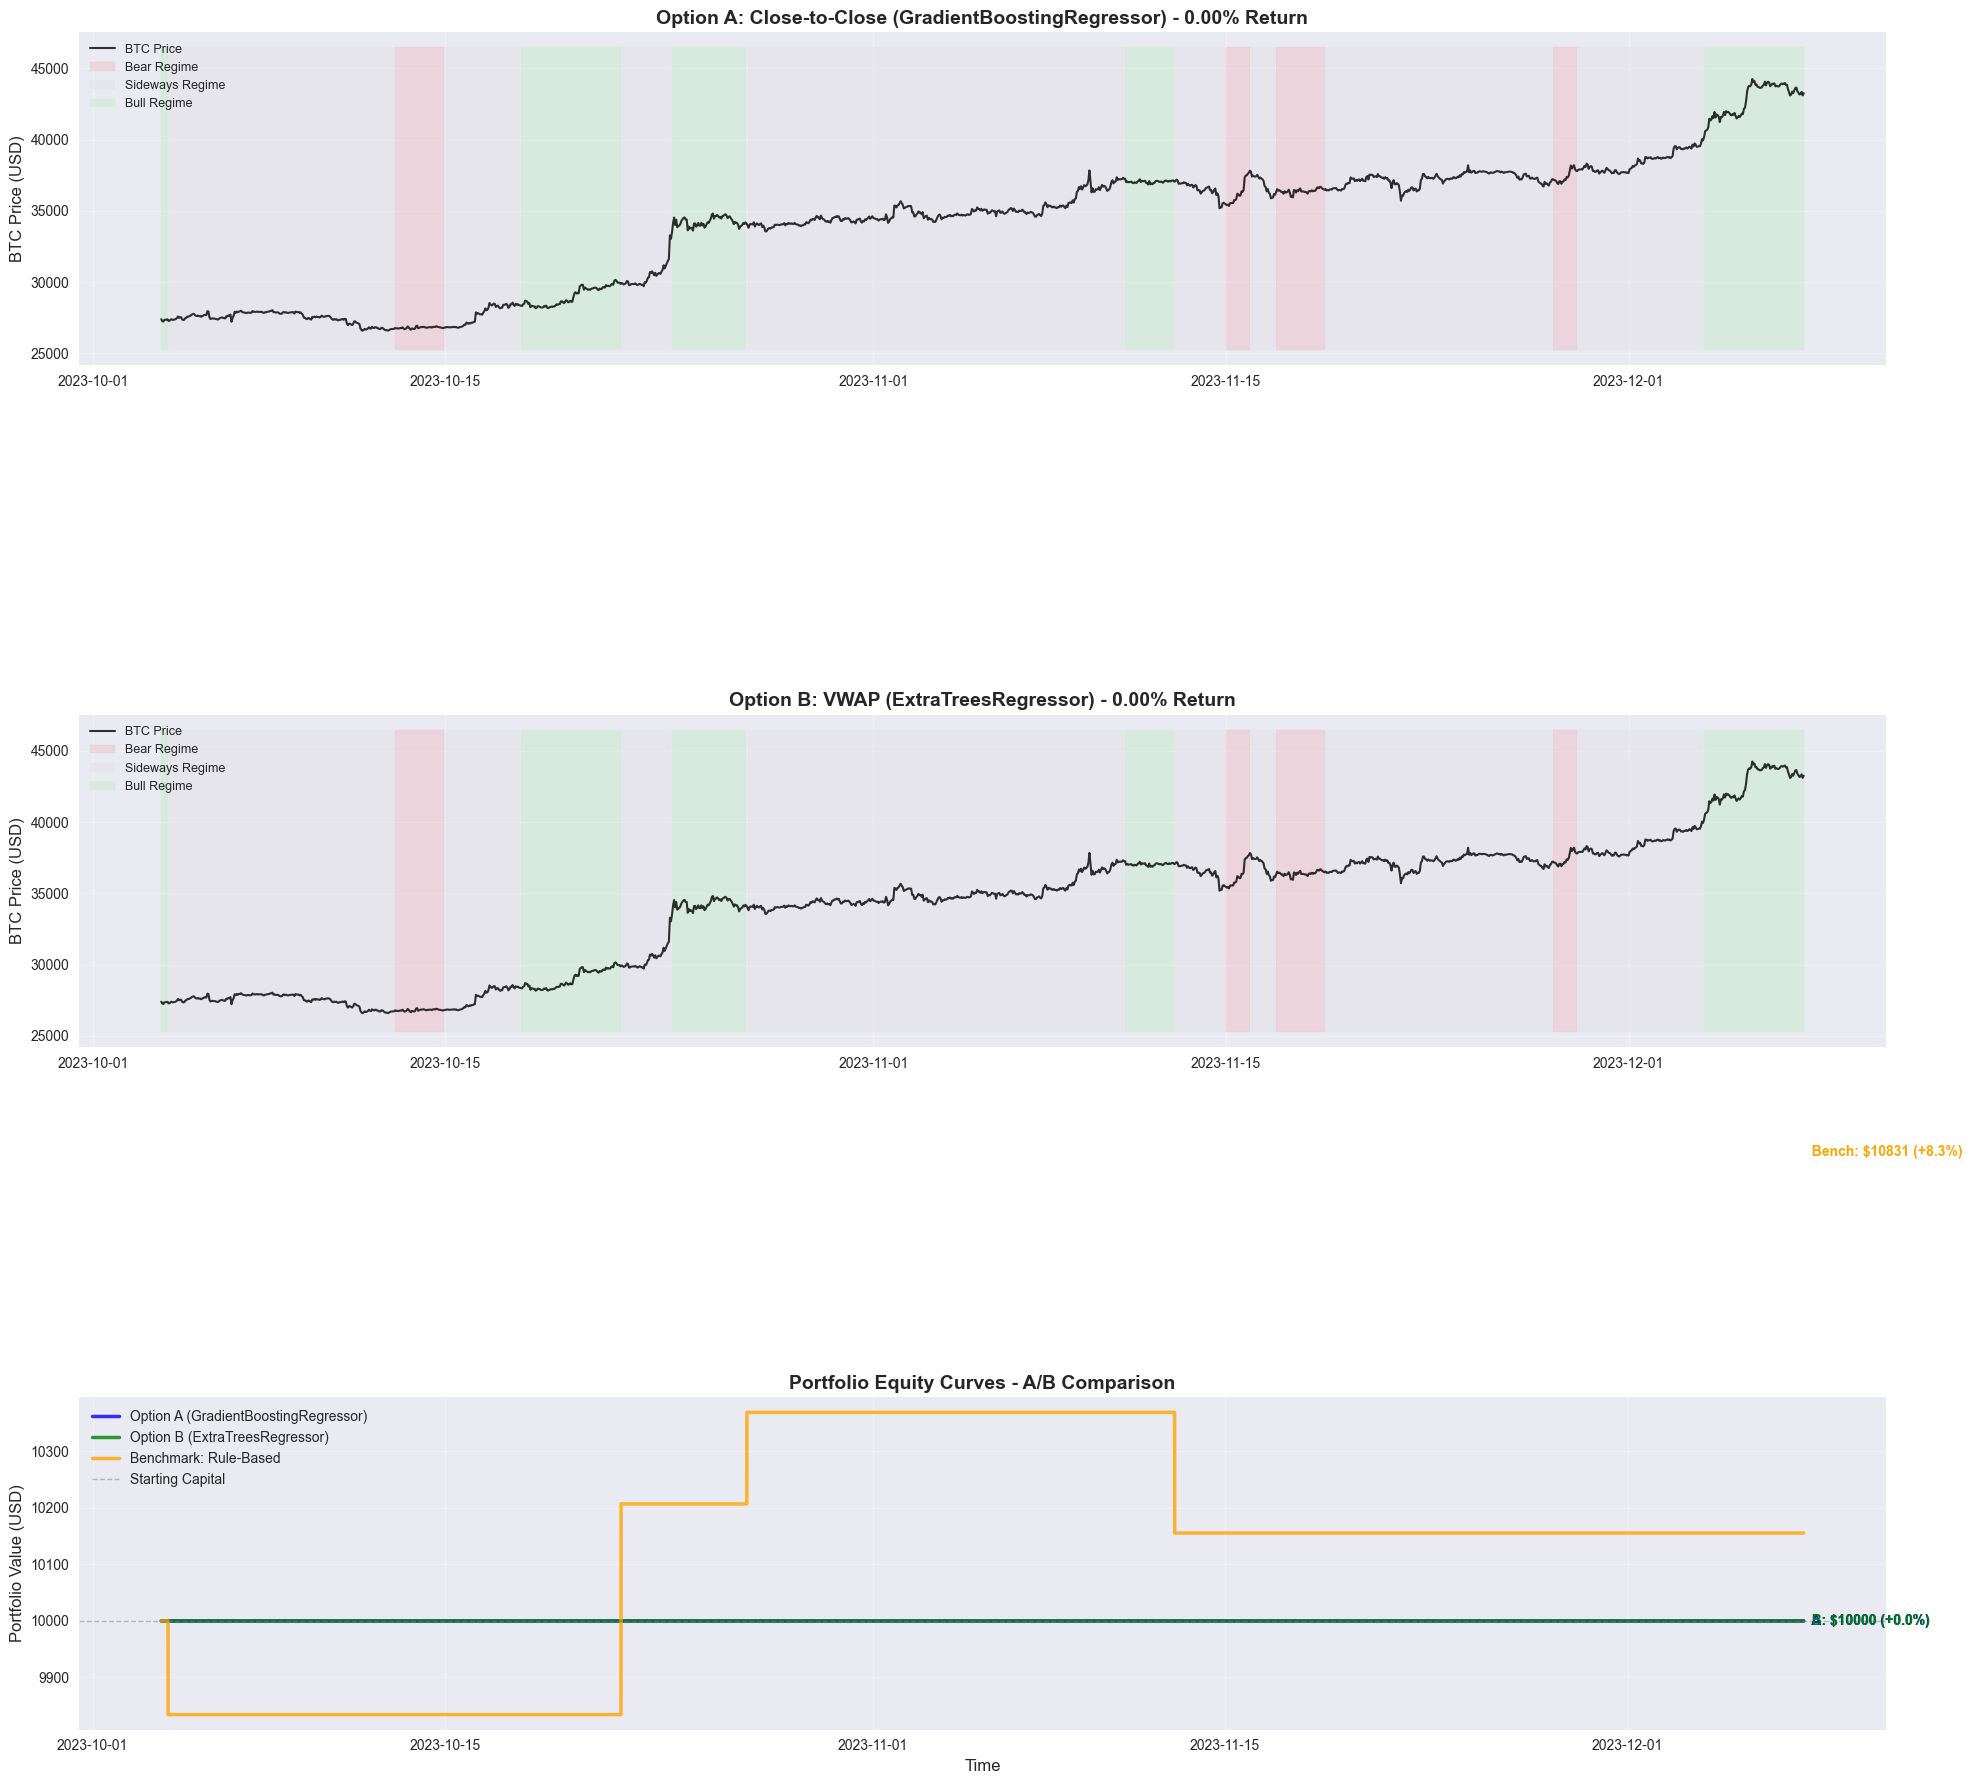


A/B TEST COMPLETE - FIXED VERSION


In [13]:
# Comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(20, 18))

# Resample to hourly
df_hourly = df_backtest.resample('1H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'regime': 'last'
}).dropna()

regime_colors = {0: 'lightcoral', 1: 'lightgray', 2: 'lightgreen'}
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}

# Plot 1: Option A
ax1 = axes[0]
ax1.plot(df_hourly.index, df_hourly['Close'], label='BTC Price', color='black', linewidth=1.5, alpha=0.8)

for regime_val in [0, 1, 2]:
    regime_mask = df_hourly['regime'] == regime_val
    if regime_mask.any():
        ax1.fill_between(df_hourly.index, 
                         df_hourly['Close'].min() * 0.95, 
                         df_hourly['Close'].max() * 1.05,
                         where=regime_mask,
                         alpha=0.2,
                         color=regime_colors[regime_val],
                         label=f'{regime_names[regime_val]} Regime')

if results_A['num_trades'] > 0:
    for _, trade in pd.DataFrame(results_A['trades']).iterrows():
        color = 'blue' if trade['return_pct'] > 0 else 'red'
        ax1.scatter(trade['entry_time'], trade['entry_price'], color='green', marker='^', s=200, zorder=5,
                   edgecolors='darkgreen', linewidths=2)
        ax1.scatter(trade['exit_time'], trade['exit_price'], color=color, marker='v', s=200, zorder=5,
                   edgecolors='darkblue' if color == 'blue' else 'darkred', linewidths=2)
        ax1.plot([trade['entry_time'], trade['exit_time']], [trade['entry_price'], trade['exit_price']],
                color=color, linestyle='--', linewidth=2, alpha=0.6)
        mid_time = trade['entry_time'] + (trade['exit_time'] - trade['entry_time']) / 2
        mid_price = (trade['entry_price'] + trade['exit_price']) / 2
        ax1.annotate(f"{trade['return_pct']:.1f}%", xy=(mid_time, mid_price),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

ax1.set_title(f'Option A: Close-to-Close ({best_model_name_A}) - {results_A["total_return"]:.2f}% Return', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('BTC Price (USD)', fontsize=12)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Option B
ax2 = axes[1]
ax2.plot(df_hourly.index, df_hourly['Close'], label='BTC Price', color='black', linewidth=1.5, alpha=0.8)

for regime_val in [0, 1, 2]:
    regime_mask = df_hourly['regime'] == regime_val
    if regime_mask.any():
        ax2.fill_between(df_hourly.index, 
                         df_hourly['Close'].min() * 0.95, 
                         df_hourly['Close'].max() * 1.05,
                         where=regime_mask,
                         alpha=0.2,
                         color=regime_colors[regime_val],
                         label=f'{regime_names[regime_val]} Regime')

if results_B['num_trades'] > 0:
    for _, trade in pd.DataFrame(results_B['trades']).iterrows():
        color = 'blue' if trade['return_pct'] > 0 else 'red'
        ax2.scatter(trade['entry_time'], trade['entry_price'], color='green', marker='^', s=200, zorder=5,
                   edgecolors='darkgreen', linewidths=2)
        ax2.scatter(trade['exit_time'], trade['exit_price'], color=color, marker='v', s=200, zorder=5,
                   edgecolors='darkblue' if color == 'blue' else 'darkred', linewidths=2)
        ax2.plot([trade['entry_time'], trade['exit_time']], [trade['entry_price'], trade['exit_price']],
                color=color, linestyle='--', linewidth=2, alpha=0.6)
        mid_time = trade['entry_time'] + (trade['exit_time'] - trade['entry_time']) / 2
        mid_price = (trade['entry_price'] + trade['exit_price']) / 2
        ax2.annotate(f"{trade['return_pct']:.1f}%", xy=(mid_time, mid_price),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

ax2.set_title(f'Option B: VWAP ({best_model_name_B}) - {results_B["total_return"]:.2f}% Return', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('BTC Price (USD)', fontsize=12)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Equity Curves
ax3 = axes[2]
time_index = df_backtest.index

ax3.plot(time_index, results_A['equity_curve'], label=f'Option A ({best_model_name_A})', 
         color='blue', linewidth=2.5, alpha=0.8)
ax3.plot(time_index, results_B['equity_curve'], label=f'Option B ({best_model_name_B})', 
         color='green', linewidth=2.5, alpha=0.8)
ax3.plot(time_index, results_benchmark['equity_curve'], label='Benchmark: Rule-Based', 
         color='orange', linewidth=2.5, alpha=0.8)

ax3.axhline(y=10000, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Starting Capital')

for results, color, name in [
    (results_A, 'blue', 'A'),
    (results_B, 'green', 'B'),
    (results_benchmark, 'orange', 'Bench')
]:
    final = results['final_capital']
    ax3.text(time_index[-1], final, f'  {name}: ${final:.0f} (+{results["total_return"]:.1f}%)',
             fontsize=10, fontweight='bold', color=color, va='center')

ax3.set_title('Portfolio Equity Curves - A/B Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ab_test_comparison_fixed.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved as: ab_test_comparison_fixed.png")
plt.show()

print("\n" + "="*70)
print("A/B TEST COMPLETE - FIXED VERSION")
print("="*70)